# <center>Decision Tree & Random Forest implementation for statistical classification

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
RANDOM_STATE = 17
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

## 1. Decision Tree

- Критерии качества разбиения

    'gini': Gini impurity $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Entropy $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.

In [4]:
def entropy(y):    
    p = [len(y[y == feature]) / len(y) for feature in np.unique(y)]
    return -np.dot(p, np.log2(p))

def gini_impurity(y):
    p = [len(y[y == feature]) / len(y) for feature in np.unique(y)]
    return 1 - np.dot(p, p)

criteria_dict = {'entropy': entropy, 'gini': gini_impurity}

- Класс узла дерева

In [5]:
class Node():
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx 
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

- Функция определения метки (берем самую часто встречающуюся)

In [6]:
def predict_leaf(y):
    return np.bincount(y).argmax()

- Функция для максимизации
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    where $X$ are samples at a given node, $X_l$ and $X_r$ are partitions of samples $X$ into two parts 
    with the following condition $[x_j < t]$, and $F(X)$ is a partition criterion.
    
- the`fit` method takes the matrix of instances `X` and a target vector `y` and returns an instance of the class `DecisionTree` representing the decision tree trained on the dataset `(X, y)` according to parameters set in the constructor

- the `predict` method takes the matrix of instances `X` and returns a prediction vector; in case of classification, prediction for an instance $x_i$ falling into leaf $L$ will be the class, mostly represented among instances in $L$.

In [7]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, criterion='gini'):
            params = {'max_depth': max_depth,
                      'min_samples_split': min_samples_split,
                      'criterion': criterion}
            self.set_params(**params)
            
    def set_params(self, **params):
        super(DecisionTree, self).set_params(**params)
        self._criterion_function = criteria_dict[self.criterion]
        if self.criterion in ['gini', 'entropy']:
            self._leaf_value = predict_leaf
        return self

    # Разбиение
    def _functional(self, X, y, feature_idx, threshold):
        mask = X[:, feature_idx] < threshold
        n_obj = X.shape[0]
        n_left = np.sum(mask)
        n_right = n_obj - n_left    
        if n_left > 0 and n_right > 0:
            return self._criterion_function(y) - (n_left / n_obj) * self._criterion_function(y[mask]) - (n_right / n_obj) * self._criterion_function(y[~mask])
        else:
            return 0
        
    def _build_tree(self, X, y, depth=1):
        max_functional = 0
        best_feature_idx = None
        best_threshold = None
        n_samples, n_features = X.shape   
        
        if len(np.unique(y)) == 1:
            return Node(labels=y)
        
        if depth < self.max_depth and n_samples >= self.min_samples_split:
            for feature_idx in range(n_features):
                threshold_values = np.unique(X[:, feature_idx])    
                functional_values = [self._functional(X, y, feature_idx, threshold) 
                                     for threshold in threshold_values]
                
                best_threshold_idx = np.nanargmax(functional_values)
                    
                if functional_values[best_threshold_idx] > max_functional:
                    max_functional = functional_values[best_threshold_idx]
                    best_threshold = threshold_values[best_threshold_idx]
                    best_feature_idx = feature_idx
                    best_mask = X[:, feature_idx] < best_threshold
    
        if best_feature_idx is not None:
            return Node(feature_idx=best_feature_idx, threshold=best_threshold, 
                        left=self._build_tree(X[best_mask, :], y[best_mask], depth + 1),
                        right=self._build_tree(X[~best_mask, :], y[~best_mask], depth + 1))
        else:
            return Node(labels=y)
        
    def fit(self, X, y):
        if self.criterion in ['gini', 'entropy']:
            self._n_classes = len(np.unique(y))
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_object(self, x, node=None):
        node = self.root
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        return self._leaf_value(node.labels)
    
    def predict(self, X):
        return np.array([self._predict_object(x) for x in X]) 

- Accuracy Score построенной функции (на примере датасета с цифрами)

In [8]:
digits = load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
tree1 = DecisionTree(max_depth=4, criterion='gini')
tree1.fit(X_train, y_train)
print(accuracy_score(tree1.predict(X_test), y_test))

0.46944444444444444


- Accuracy Score модели из sklearn для тех же выборках

In [9]:
tree2 = DecisionTreeClassifier(max_depth=4, criterion='gini')
tree2.fit(X_train, y_train)
print(accuracy_score(tree2.predict(X_test), y_test))

0.5638888888888889


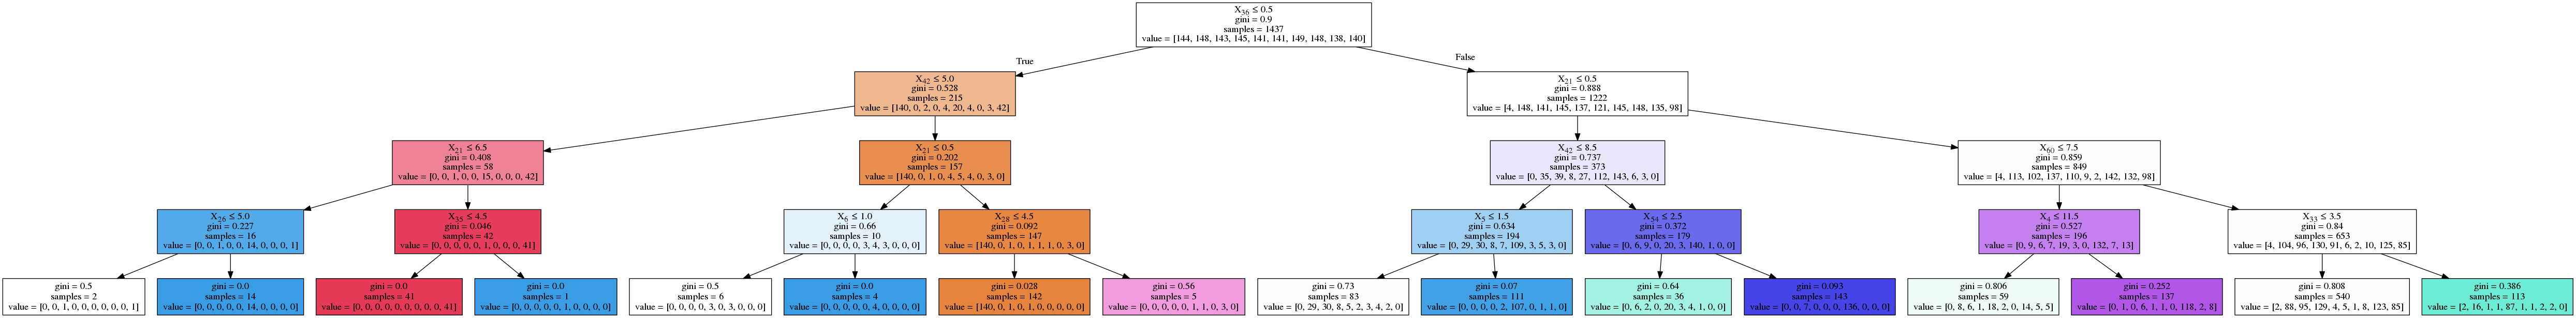

In [17]:
dot_data = StringIO()
export_graphviz(tree2, out_file=dot_data, filled=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## 2. Random Forest

In [20]:
data = pd.read_csv('credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [25]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

In [26]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
table = impute_nan_with_median(data)
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

Brief specification:
 - Use the base code below
 - In the `fit` method in the loop (`i` from 0 to `n_estimators-1`), fix the seed equal to (`random_state + i`). The idea is that at each iteration there's a new value of random seed to add more "randomness", but at hte same time results are reproducible
 - After fixing the seed, select `max_features` features **without replacement**, save the list of selected feature ids in `self.feat_ids_by_tree`
 - Also make a bootstrap sample (i.e. **sampling with replacement**) of training instances. For that, resort to `np.random.choice` and its argument `replace`
 - Train a decision tree with specified (in a constructor) arguments `max_depth`, `max_features` and `random_state` (do not specify `class_weight`) on a corresponding subset of training data. 
 - The `fit` method returns the current instance of the class `RandomForestClassifierCustom`, that is `self`
 - In the `predict_proba` method, we need to loop through all the trees. For each prediction, obviously, we need to take only those features which we used for training the corresponding tree. The method returns predicted probabilities (`predict_proba`), averaged for all trees


In [21]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=10, max_features=10, 
                 random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        
        self.trees = []
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
            for i in range(self.n_estimators):
                np.random.seed(self.random_state + i)
                col_indices = np.random.choice(range(X.columns.shape[0]), size=self.max_features, replace=False)
                self.feat_ids_by_tree.append(col_indices)
                row_indices = np.random.randint(0, len(X), size=len(X))
                sample_X= X.iloc[row_indices, col_indices]
                sample_y = y[row_indices]
                dt = DecisionTreeClassifier(
                    max_depth=self.max_depth,
                    max_features=self.max_features,
                    random_state=self.random_state)
                dt.fit(sample_X, sample_y)
                self.trees.append(dt)
                
    def predict_proba(self, X):
        predictions = None
        for ti, tree in enumerate(self.trees):
            indicies = self.feat_ids_by_tree[ti]
            sample_X = X.iloc[:, indicies]
            if predictions is None:
                predictions = tree.predict_proba(sample_X)
            else:
                predictions += tree.predict_proba(sample_X)
        return predictions / len(self.trees)

- Кросс-валидация для построенного леса (на примере кредитного скоринга)

In [27]:
rf = RandomForestClassifierCustom(max_depth=7, max_features=6)
rf.fit(X, y)

In [31]:
np.mean(cross_val_score(rf, X, y.values, cv=skf, scoring='roc_auc'))

0.8323967442439001

- Кросс-валидация для модели из sklearn

In [32]:
rf = RandomForestClassifier(max_depth=7, max_features=6, class_weight='balanced', random_state=17)
rf.fit(X, y)
np.mean(cross_val_score(rf, X, y.values, cv=skf, scoring='roc_auc'))

0.8291436207462765